In [ ]:
#@title 

import tensorflow as tf
import keras
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.optimizers import SGD

from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate

from keras import backend as K
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalAveragePooling1D
from keras import backend as K

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate

import pandas as pd
import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def one_hot(col_name,df1):
  one_hot = pd.get_dummies(df[col_name])
  # Drop column B as it is now encoded
  df1 = df1.drop(col_name,axis = 1)
  # Join the encoded df
  df1 = df1.join(one_hot)
  return df1


def shift(col_name,df1,number):
  df1[col_name] = df1[col_name].shift(number)
  return df1

def split_x_y(df,k):
    y = df[k]
    x = df
    x = x.drop([k], axis = 1)
    
    return x,y


def data_pipeline(df):
   
    df = one_hot('Grade&Bwt',df)
    #df = shift('SheetBreak',df,-1)
    df = one_hot('EventPress',df)
    #df.drop(df.tail(1).index,inplace=True)

    x,y = split_x_y(df2,'SheetBreak')
    x.drop(['DateTime'], axis = 1, inplace= True)
    
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state= 123) 

    return X_train, X_test, y_train, y_test 

def classification_model(model_name,x_train,y_train,x_val,y_val):
    model = model_name  
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    
    
    confusion = confusion_matrix(y_val, y_pred)
    print(confusion)
    print(classification_report(y_val, y_pred))
    print("Accuracy is", model.score(x_val,y_val))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# In google colab, run the following cell to train your model on TPU.

In [ ]:
#Use this below code only when TPU is needed!

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)



resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
# Curve_shift will effectively shift the Y variable with the desired early prediction time.

## ex: if the aim is to predict 2 minutes early, then it will just move up all the one's up by one row and. (Since each row in dataset is at a 2 minute interval) 
## and it will also delete the original rows with breakdown, since the signal is strongest at the time of breakdown and will distort our model.

In [ ]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''
    
    vector = df['SheetBreak'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'SheetBreak'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [ ]:
#One hot encoding the categorial variables and splitting the data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/processminer-sheet-break-rare-event-dataset.csv')

In [ ]:
df['SheetBreak'].value_counts()

0    20323
1      135
Name: SheetBreak, dtype: int64

In [ ]:
df = curve_shift(df,-2)

In [ ]:
df['SheetBreak'].value_counts()

0.0    20054
1.0      269
Name: SheetBreak, dtype: int64

In [ ]:
df = one_hot('Grade&Bwt',df)
df = one_hot('EventPress',df)

In [ ]:
x,y = split_x_y(df,'SheetBreak')
x.drop(['DateTime'], axis = 1, inplace= True)

In [ ]:

#SPLITTING INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(
x, y, test_size=0.15, random_state= 123, stratify = y) 

In [ ]:
y_train.value_counts()

0.0    17045
1.0      229
Name: SheetBreak, dtype: int64

In [ ]:
y_test.value_counts()

0.0    3009
1.0      40
Name: SheetBreak, dtype: int64

In [ ]:
# Standardized the data, as standardized data is very important for neural networks., which leads to faster convergence of the loss function.
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
#CHECKPOINTING THE MODEL IS ALSO REALLY IMPORTANT
checkpoint = ModelCheckpoint("/content/DL4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                828       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Sample model
with strategy.scope():
  model = Sequential()
  model.add(Dense(16, input_dim=68, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit the keras model on the dataset
  model.fit(X_train, y_train, epochs=50, batch_size=128, callbacks = [checkpoint] , validation_data= (X_test,y_test))

Epoch 1/50
  1/135 [..............................] - ETA: 1:07 - loss: 0.7018 - accuracy: 0.4922WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 0.0155s). Check your callbacks.


132/135 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9412WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_test_batch_end` time: 0.0140s). Check your callbacks.


135/135 [==============================] - 4s 30ms/step - loss: 0.2088 - accuracy: 0.9422 - val_loss: 0.0740 - val_accuracy: 0.9869
Epoch 2/50
135/135 [==============================] - 3s 21ms/step - loss: 0.0721 - accuracy: 0.9867 - val_loss: 0.0680 - val_accuracy: 0.9869
Epoch 3/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0683 - accuracy: 0.9867 - val_loss: 0.0657 - val_accuracy: 0.9869
Epoch 4/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0663 - accuracy: 0.9867 - val_loss: 0.0653 - val_accuracy: 0.9869
Epoch 5/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0648 - accuracy: 0.9867 - val_loss: 0.0646 - val_accuracy: 0.9869
Epoch 6/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0634 - accuracy: 0.9867 - val_loss: 0.0645 - val_accuracy: 0.9869
Epoch 7/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0624 - accuracy: 0.9867 - val_loss: 0.0646 - val_accuracy: 0.9869
Epoch 8/50

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size= 128)
test_predictions_baseline = model.predict(X_test, batch_size= 128)

In [ ]:
def plot_cm(labels, predictions, p=0.05):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non Breakdowns correctly identified (True Negatives): ', cm[0][0])
  print('Non Breakdowns Detected as Breakdowns  (False Positives): ', cm[0][1])
  print('Machine Breakdowns Missed (False Negatives): ', cm[1][0])
  print('Machine Breakdowns Detected (True Positives): ', cm[1][1])
  print('Total Sheet Breaks: ', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size= 128, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
  print()

loss :  0.0638393983244896

accuracy :  0.9865530133247375



loss :  0.0638393983244896

accuracy :  0.9865530133247375

Non Breakdowns correctly identified (True Negatives):  2880
Non Breakdowns Detected as Breakdowns  (False Positives):  129
Machine Breakdowns Missed (False Negatives):  24
Machine Breakdowns Detected (True Positives):  16
Total Sheet Breaks:  40


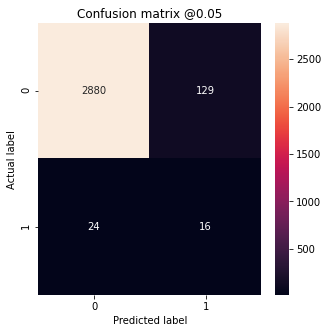

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size= 128, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
  print()

plot_cm(y_test, test_predictions_baseline) 

In [ ]:
# with a Recall of 67% and a precision of 11% this model can result in significant savings for the paper industry.